# Project 13.  CIFAR-10 이미지 생성하기

__생성 모델링__

* 판별 모델 : 입력 받은 데이터를 특정 기준에 대해 판별하는 것인 목적인 모델 

* 생성 모델 : 학습한 데이터셋과 비슷하지만 기존에 없는 새로운 데이터 셋을 생성하는 모델

  생성 모델은 다른 판별 모델을 학습시키는데 필요한 데이터를 생성할 수 있다. 



__1. Pix2Pix : 그림을 사진으로__

Pix2Pix는 간단한 이미지를 입력했을 때, 실제 사진처럼 보이도록 바꿀 때 많이 사용하는 모델이다. 

단순화된 이미지(input image)와 실제 이미지(ground truth)가 쌍을 이루는 데이터셋으로 학습을 진행한다 (imput image를 입력 받으면, 내부 연산을 통해 실제 사진과 같이 변화된 predicted image를 출력). 

학습 초기에는 모델이 생성한 predicted image가 실제 이미지와 다르지만 계속해서 실제 이미지와 얼마나 비슷한지 평가하며 실제 이미지와 비슷한 결과물을 만들어 내게 된다. 이렇게 픽셀 단위로 변환한다는 뜻의 Pixel to Pixel을 딴 Pix2Pix로 이름이 붙게 되었다. 



__2. CycleGAN : 그림을 사진으로, 사진을 그림으로__

Pix2Pix 이후 모델로는 CycleGAN이 있다. 이 모델은 한 이미지와 다른 이미지를 번갈아 가며 Cyclic하게 변환시킨다. 

한 방향 변환만 가능한 Pix2Pix와 달리 CycleGAN은 양방향 이미지 변환이 가능하고 쌍을 이루지 않은 데이터 셋으로도 학습이 가능하다. 얼룩말을 말로, 말을 얼룩말로 변환할 경우, 모델이 스스로 얼룩말과 말 데이터에서 각각의 스타일을 학습해 새로운 이미지에 학습한 스타일을 적용할 수 있도록 설계되었기 때문에 쌍을 이루지 않더라도 얼룩말과 말의 각각의 데이터 셋으로도 CycleGAN을 학습시킬 수 있다. 

쌍으로 된 데이터가 필요하지 않다는 것은 데이터를 구하기 더 쉽고 라벨을 붙이는 주석 비용이 필요 없기 때문에 큰 장점이다. 

다른 유명한 사례는 실제 사진을 화가가 그린 그림처럼 바꾸는 것이다. 양방향 이미지 변환이 가능하기 때문에 그림을 실제 사진으로 바꾸는 것도 가능하다. 



__3. Neural Style Transfer : 원하는 스타일 입히기__

이 기법은 이미지의 스타일을 변환시킨다. 전체 이미지의 구성을 유지할 base image와 스타일이 담긴 style image를 통해 새로운 이미지를 만들어 낸다. 



__Fashin MNIST__

패션 디자이너들은 다양한 패션을 많이 접하고 좋은 패션이 무엇인지 학습한 뒤 학습을 토대로 자신만의 디자인을 완성한다. 생성 모델도 같다. 

손글씨 숫자 데이터은 MNIST와 비슷한 형태의 데이터셋으로 `28x28`크기의 70,000장의 데이터로 이루어져 있다. 총 10개의 패션 카테고리가 아래와 같이 labeling되어 있다. 

## STEP 0. 작업환경 구성하기

```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

## STEP 1. 데이터셋 구성하기

In [12]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

__1.1 train_x의 이미지 정규화__

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel   :", train_x.max())
print("min pixel   :", train_x.min())
print("train shape :", train_x.shape)

max pixel   : 1.0
min pixel   : -1.0
train shape : (50000, 32, 32, 3)


__1.2 학습 데이터 시각화__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

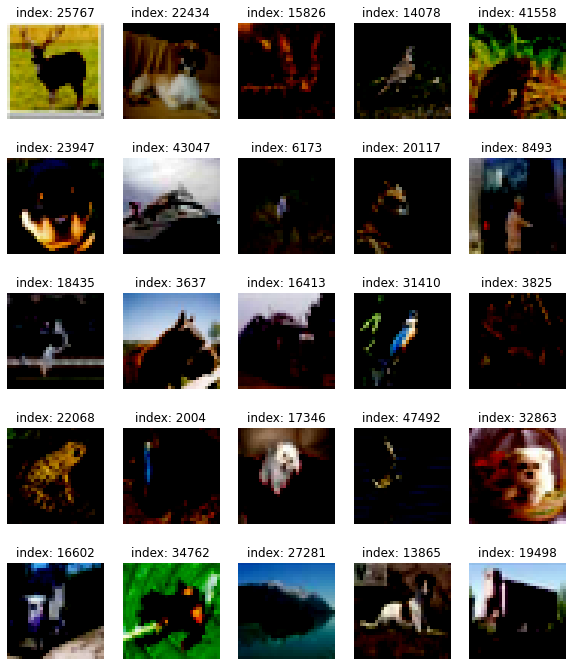

In [6]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

__1.3 미니배치 데이터셋을 구성__

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기

__2.1 생성자 모델 구현 함수__

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

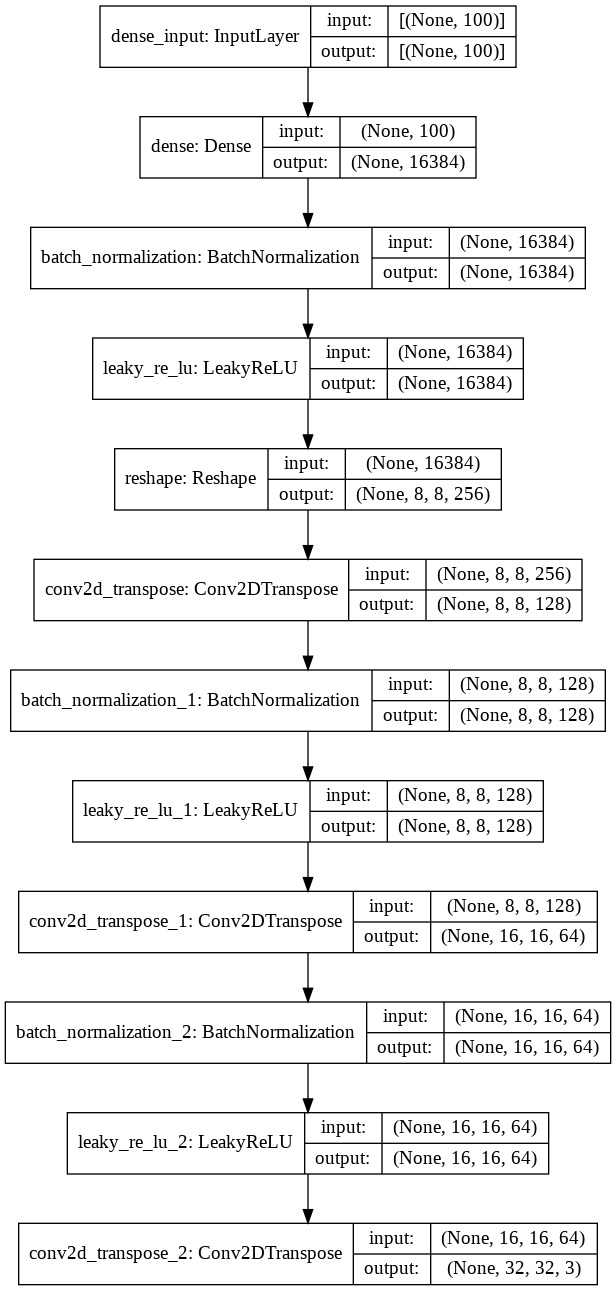

In [13]:
plot_model(generator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

__2.2 구현한 생성자로 랜덤 이미지를 생성__

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

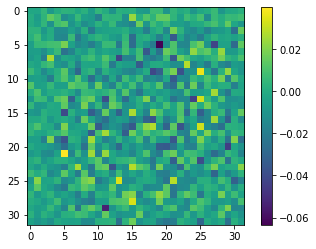

In [16]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기

__3.1 판별자 모델 구현 함수를 작성해 봅시다.__

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

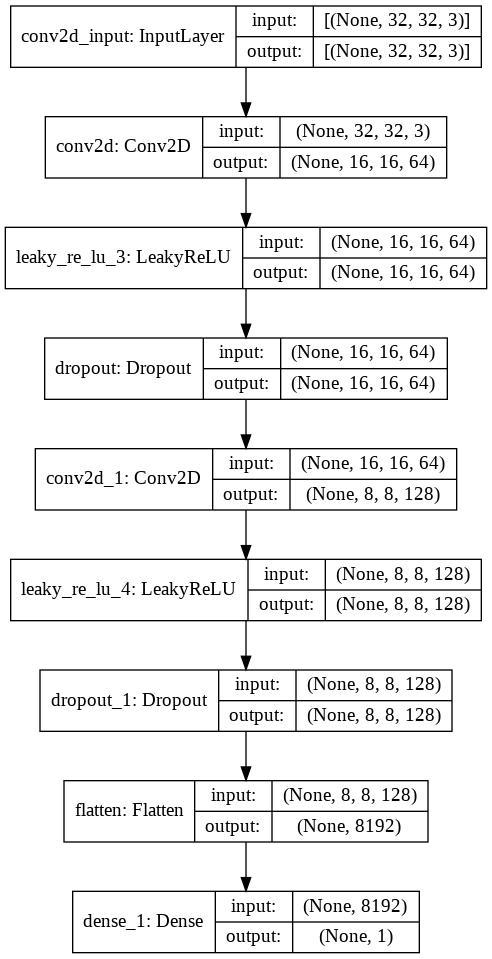

In [19]:
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00068291]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기

__4.1 생성자와 판별자의 손실함수(loss)__

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

__4.2 이미지 판별 정확도(accuracy) 함수__

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

__4.3 optimizer를 정의__

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, decay=1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 5. 훈련과정 상세 기능 구현하기

__5.1 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수__

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

__5.2 이미지를 시각화하는 generate_and_save_images() 함수__

In [28]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_1/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format( epoch, it))

    plt.show()

__5.3 그래프로 시각화하는 draw_train_history() 함수__ 

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_1/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

__checkpoint 모듈__

In [30]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_1/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기


In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [36]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

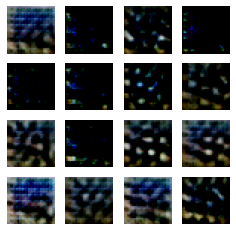

Time for training : 1470 sec


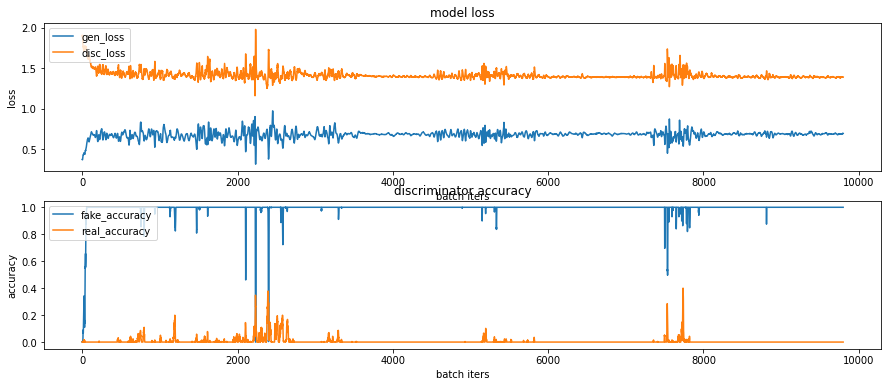

CPU times: user 24min 32s, sys: 16.2 s, total: 24min 48s
Wall time: 24min 31s


In [37]:
%%time
train(train_dataset, EPOCHS, save_every)

In [38]:
anim_file = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_1/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_1/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [39]:
!ls -l /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_1/cifar10_dcgan.gif

-rw------- 1 root root 1166549 Sep  2 09:49 /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_1/cifar10_dcgan.gif


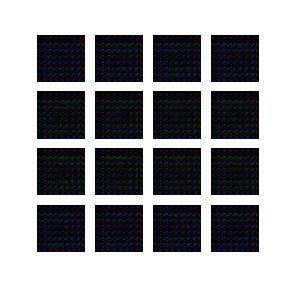

In [40]:
from IPython.display import Image

Image(open(anim_file,'rb').read())

# 개선하기1

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(256*4*4, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128,(4, 4),  strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128,(4, 4),  strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128,(4, 4),  strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3,(3, 3), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 4096)              413696    
_________________________________________________________________
batch_normalization_39 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_39 (Conv2DT (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_40 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 8, 8, 128)       

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

In [ ]:
def make_discriminator_model(in_shape=(32,32,3)):

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4096)            

In [ ]:
decision = discriminator(generated_image, training=False)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_2/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format( epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_2/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_2/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
save_every = 10
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

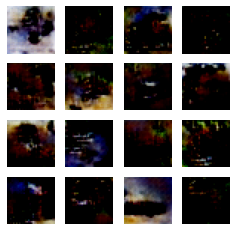

Time for training : 5471 sec


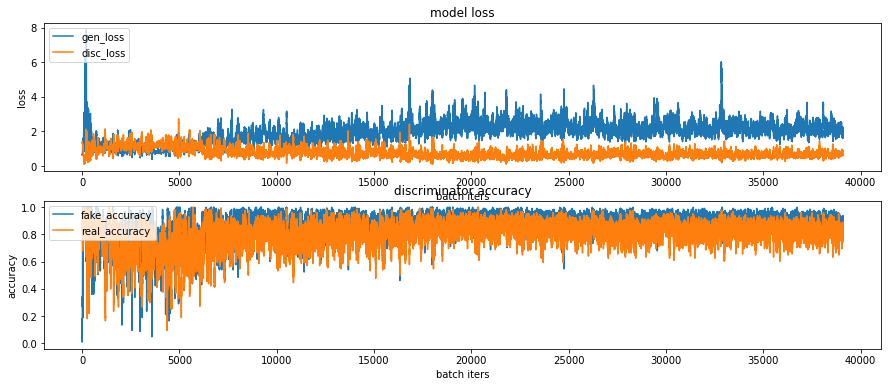

CPU times: user 1h 32min 32s, sys: 1min 23s, total: 1h 33min 55s
Wall time: 1h 31min 13s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

https://ichi.pro/ko/ganeul-sayonghayeo-keras-mich-cifar10-deiteo-seteuleul-sayonghayeo-sasiljeog-in-imiji-saengseong-138292884269460

# 개선하기 2

In [61]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.


BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [62]:
def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [63]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_7 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 4, 4, 256)         1638400   
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4, 4, 256)        

In [64]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [65]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [66]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)        

In [67]:
decision = discriminator(generated_image, training=False)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, decay = 1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [68]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [69]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [70]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [78]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, decay=1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, decay=1e-4)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [72]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [73]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_3/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format( epoch, it))

    plt.show()

In [74]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_3/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [75]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_3/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [76]:
save_every = 20
EPOCHS = 400


tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

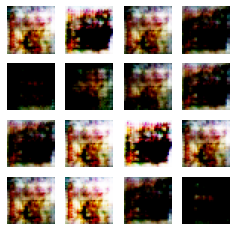

Epoch 363 | iter 1
Time for epoch 363 : 1 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_3/cifar10_dcgan3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_3/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
!ls -l /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10_3/cifar10_dcgan3.gif

In [ ]:
from IPython.display import Image

Image(open(anim_file,'rb').read())

기본 모형

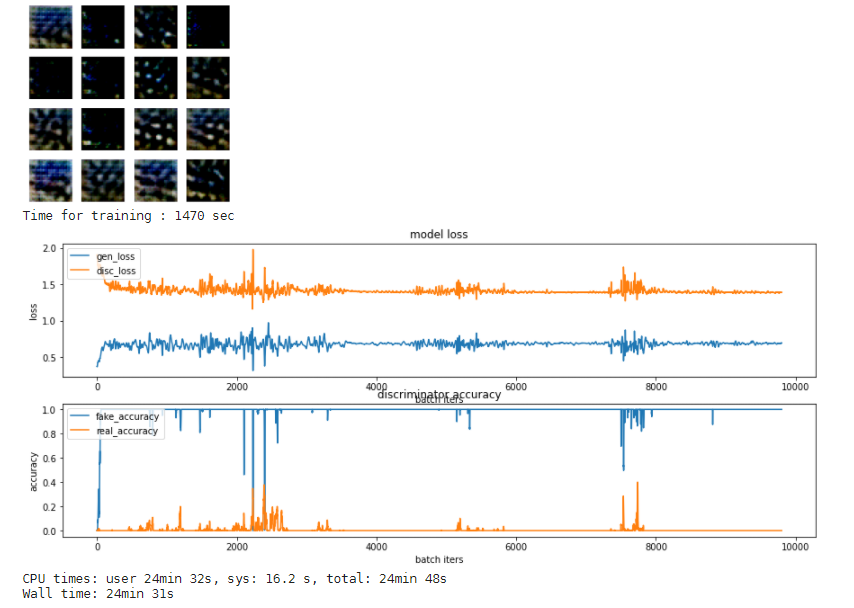


__optimizer변경, layer 추가__

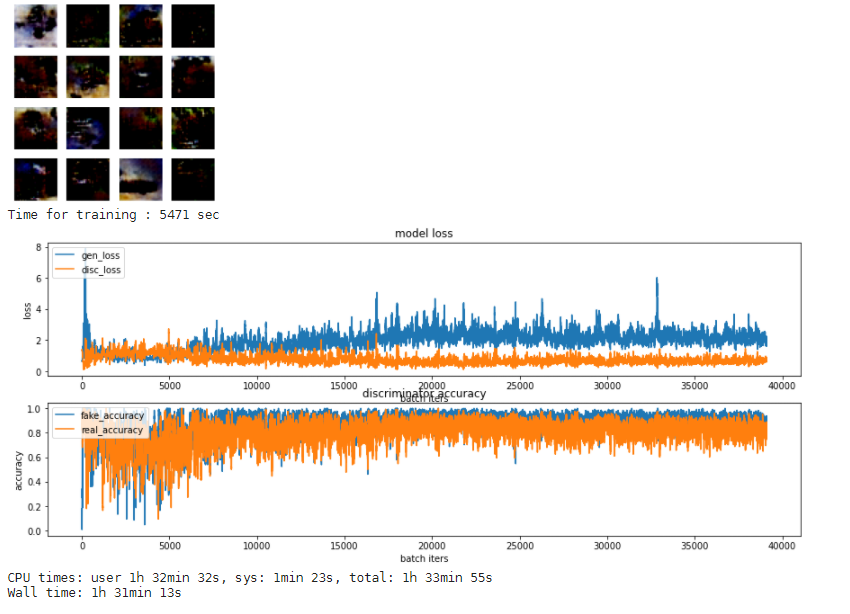

__optimizer변경, layer 추가, epochs = 400__




# 회고 
5시간이 걸리는 모형도 그림이 잘 나오지 않았다 .. 

어떤게 문제인지 제출기한이 끝나도 알아보고 싶다. epoch를 늘리고 레이어를 추가하면 좋은 결과가 나올것으로 예상했는데 그러지 않아서 슬프다. 오래 걸리다 보니 GPU 연결이 자주끊겨 그림을 그리지 못한게 아쉽다. 

결과가 눈에 보이면 이해하는데 도움이 더 될 것 같은데 그러지 못해 아쉬운 노드였다. 

그래도 참고한 사이트와 노드를 비교하면서 층을 추가하고 하이퍼파라미터 값을 변경해보면서 모델을 이해하는데 도움이 되었다. 

하지만 결과를 보면 이해를 못한 것 같다 .. 더 열심히 해야겠다! 